In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchtext
from torchtext.data import get_tokenizer
import spacy
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab as build_vocab
from torch.utils.data import DataLoader, TensorDataset
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/var/folders/8v/z7_lynrn24bbpwy6p36j3cwc0000gn/T/ipykernel_68226/2765435904.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/chaiharsha/Documents/course_classifier/courseenvfull/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Us

In [2]:
df = pd.read_csv('courses.csv')
df.head()

,Course,ID,Department
0,Principles of Nutrition,BIOL,Biology
1,Nutrition for Fitness and Physical Activity,BIOL,Biology
2,Introduction to Human Physiology,BIOL,Biology
3,Biotechnology Management,BIOL,Biology
4,Living Biology at Brown and Beyond,BIOL,Biology


In [3]:
text = df['Course']
labels_text = df['Department']

In [4]:
text_list = text.tolist()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
encoded = tokenizer(text_list, padding=True, return_tensors='np')
sequences = encoded['input_ids']
print(sequences.shape)
max_length = sequences.shape[1]

(6690, 26)


In [5]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_text)
output_dim = len(label_encoder.classes_)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels_encoded, test_size=0.2, random_state=17)
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=output_dim)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
for param in model.distilbert.parameters():
    param.requires_grad = False

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [10]:
def train_loop(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0        

        for inputs, targets in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * targets.size(0)
            correct += (outputs.argmax(1) == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).logits
                loss = loss_fn(outputs, targets)

                val_loss += loss.item() * targets.size(0)
                val_correct += (outputs.argmax(1) == targets).sum().item()
                val_total += targets.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

In [11]:
history = train_loop(model, train_loader, test_loader, loss_fn, optimizer, 60)
torch.save(model.state_dict(), "finetune_bert_torch.pth")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/60: Train Loss: 3.4835, Train Acc: 0.1381 | Val Loss: 2.9862, Val Acc: 0.2025
Epoch 2/60: Train Loss: 2.9920, Train Acc: 0.2063 | Val Loss: 2.7173, Val Acc: 0.2556
Epoch 3/60: Train Loss: 2.7798, Train Acc: 0.2507 | Val Loss: 2.5498, Val Acc: 0.3191
Epoch 4/60: Train Loss: 2.6399, Train Acc: 0.2818 | Val Loss: 2.4809, Val Acc: 0.3072
Epoch 5/60: Train Loss: 2.5336, Train Acc: 0.3135 | Val Loss: 2.4023, Val Acc: 0.3288
Epoch 6/60: Train Loss: 2.4802, Train Acc: 0.3132 | Val Loss: 2.2952, Val Acc: 0.3610
Epoch 7/60: Train Loss: 2.4240, Train Acc: 0.3315 | Val Loss: 2.3452, Val Acc: 0.3558
Epoch 8/60: Train Loss: 2.3992, Train Acc: 0.3391 | Val Loss: 2.2598, Val Acc: 0.3513
Epoch 9/60: Train Loss: 2.3604, Train Acc: 0.3459 | Val Loss: 2.1866, Val Acc: 0.3849
Epoch 10/60: Train Loss: 2.3157, Train Acc: 0.3567 | Val Loss: 2.1735, Val Acc: 0.3999
Epoch 11/60: Train Loss: 2.2794, Train Acc: 0.3679 | Val Loss: 2.1066, Val Acc: 0.4073
Epoch 12/60: Train Loss: 2.2629, Train Acc: 0.3703 |

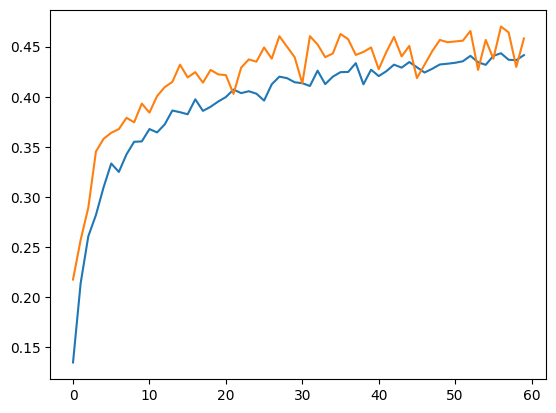

In [13]:
plt.plot(history['train_acc'], label='accuracy')
plt.plot(history['val_acc'], label='val_accuracy')

In [20]:
predict_text = "Imperial Republicanism in Antiquity"
tokens = tokenizer(predict_text, return_tensors="pt")
sequence = tokens['input_ids']
with torch.no_grad():
    model.eval()
    output = model(sequence)
    logits = output.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    top_probs, top_indices = torch.topk(probabilities, k=5)
    top_probs = top_probs.squeeze().tolist()
    top_indices = top_indices.squeeze().tolist()

    print(f"Top 5 predicted departments for '{predict_text}':")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        department = label_encoder.inverse_transform([idx])[0]
        print(f"{i+1}. {department}: {prob*100:.2f}%")

Top 5 predicted departments for 'Imperial Republicanism in Antiquity':
1. History: 96.92%
2. Classics: 1.56%
3. Archaeology: 1.04%
4. Art History: 0.15%
5. Political Science: 0.05%
